In [1]:
import numpy as np
import pandas as pd

import re
import string
import ssl

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc

import matplotlib.pyplot as plt


2026-02-07 14:10:06.815103: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-07 14:10:06.982134: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-02-07 14:10:06.982216: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-02-07 14:10:07.010487: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-07 14:10:07.077395: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-07 14:10:07.078876: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download("omw-1.4")

[nltk_data] Downloading package stopwords to /home/ana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/ana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ana/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

In [3]:
STOPWORDS = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()
token = RegexpTokenizer(r'[a-zA-Z0-9]+')

In [4]:
def clean_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r"<.*?>", " ", text)
    text = re.sub(r"https?://\S+", "", text)
    text = re.sub(r"\d+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))

    tokens = token.tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in STOPWORDS]
    return " ".join(tokens)

In [5]:
df = pd.read_csv("data/IMDB Dataset.csv")
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df['review'].iloc[1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [7]:
df["label"] = df["sentiment"].map({"positive": 1, "negative": 0})
df.head()

,review,sentiment,label
0,One of the other reviewers has mentioned that ...,positive,1
1,A wonderful little production. <br /><br />The...,positive,1
2,I thought this was a wonderful way to spend ti...,positive,1
3,Basically there's a family where a little boy ...,negative,0
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1


In [8]:
df['cleaned_review'] = df['review'].apply(clean_text)
df.head()

,review,sentiment,label,cleaned_review
0,One of the other reviewers has mentioned that ...,positive,1,one reviewer mentioned watching oz episode you...
1,A wonderful little production. <br /><br />The...,positive,1,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,1,thought wonderful way spend time hot summer we...
3,Basically there's a family where a little boy ...,negative,0,basically there family little boy jake think t...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,1,petter matteis love time money visually stunni...


In [9]:
df['cleaned_review'].iloc[1]

'wonderful little production filming technique unassuming oldtimebbc fashion give comforting sometimes discomforting sense realism entire piece actor extremely well chosen michael sheen got polari voice pat truly see seamless editing guided reference williams diary entry well worth watching terrificly written performed piece masterful production one great master comedy life realism really come home little thing fantasy guard rather use traditional dream technique remains solid disappears play knowledge sens particularly scene concerning orton halliwell set particularly flat halliwells mural decorating every surface terribly well done'

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   review          50000 non-null  object
 1   sentiment       50000 non-null  object
 2   label           50000 non-null  int64 
 3   cleaned_review  50000 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.5+ MB


In [11]:
df.shape

(50000, 4)

In [12]:
df = df.drop_duplicates()

In [13]:
df.shape

(49582, 4)

In [14]:
df = df[['cleaned_review','label']]

In [15]:
df

,cleaned_review,label
0,one reviewer mentioned watching oz episode you...,1
1,wonderful little production filming technique ...,1
2,thought wonderful way spend time hot summer we...,1
3,basically there family little boy jake think t...,0
4,petter matteis love time money visually stunni...,1
...,...,...
49995,thought movie right good job wasnt creative or...,1
49996,bad plot bad dialogue bad acting idiotic direc...,0
49997,catholic taught parochial elementary school nu...,0
49998,im going disagree previous comment side maltin...,0


In [16]:
X_text = df["cleaned_review"].astype(str).values
y = df["label"].values

In [17]:
X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

In [18]:
X_train_text, X_val_text, y_train, y_val = train_test_split(
    X_train_text, y_train, test_size=0.1, random_state=42, stratify=y_train
)

In [19]:
MAX_VOCAB = 20000
MAX_LEN = 200  

tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train_text)

train_seq = tokenizer.texts_to_sequences(X_train_text)
test_seq  = tokenizer.texts_to_sequences(X_test_text)

X_train = pad_sequences(train_seq, maxlen=MAX_LEN, padding="post", truncating="post")
X_val = pad_sequences(tokenizer.texts_to_sequences(X_val_text),maxlen=MAX_LEN, padding="post", truncating="post")
X_test  = pad_sequences(test_seq,  maxlen=MAX_LEN, padding="post", truncating="post")
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((35698, 200), (9917, 200), (35698,), (9917,))

In [20]:
model = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN,mask_zero=True),
    LSTM(128, return_sequences=False),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model.summary()

model2 = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN,mask_zero=True),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
model2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
model2.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          2560000   
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 2691713 (10.27 MB)
Trainable params: 2691713 (10.27 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param

In [21]:
early = EarlyStopping(
    monitor='val_loss',       
    patience=2,                
    restore_best_weights=True 
)

In [22]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early],
    verbose=1
)

Epoch 1/10
558/558 [==============================] - 103s 180ms/step - loss: 0.3810 - accuracy: 0.8319 - val_loss: 0.3188 - val_accuracy: 0.8702
Epoch 2/10
558/558 [==============================] - 101s 181ms/step - loss: 0.2277 - accuracy: 0.9159 - val_loss: 0.3085 - val_accuracy: 0.8790
Epoch 3/10
558/558 [==============================] - 101s 180ms/step - loss: 0.1497 - accuracy: 0.9476 - val_loss: 0.3564 - val_accuracy: 0.8654
Epoch 4/10
558/558 [==============================] - 101s 180ms/step - loss: 0.0983 - accuracy: 0.9666 - val_loss: 0.4600 - val_accuracy: 0.8634


In [23]:
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=64,
    callbacks=[early],
    verbose=1
)

Epoch 1/10
558/558 [==============================] - 61s 105ms/step - loss: 0.3534 - accuracy: 0.8452 - val_loss: 0.3285 - val_accuracy: 0.8629
Epoch 2/10
558/558 [==============================] - 58s 104ms/step - loss: 0.1966 - accuracy: 0.9283 - val_loss: 0.3501 - val_accuracy: 0.8624
Epoch 3/10
558/558 [==============================] - 58s 104ms/step - loss: 0.1311 - accuracy: 0.9525 - val_loss: 0.3959 - val_accuracy: 0.8636


In [24]:
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"LSTM Accuracy 1: {accuracy*100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

310/310 [==============================] - 18s 54ms/step
LSTM Accuracy 1: 88.24%

Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.88      0.88      4940
           1       0.88      0.89      0.88      4977

    accuracy                           0.88      9917
   macro avg       0.88      0.88      0.88      9917
weighted avg       0.88      0.88      0.88      9917



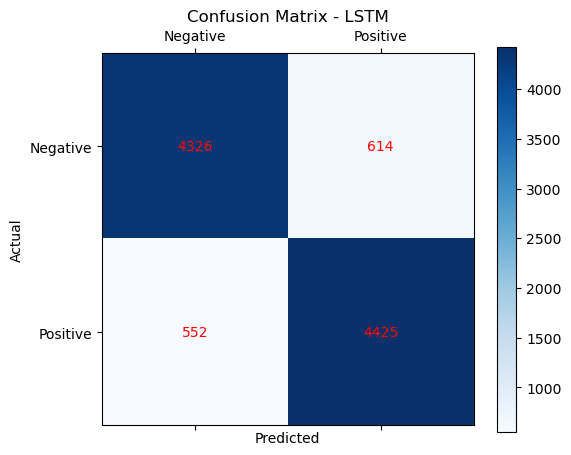

In [25]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6,5))
cax = ax.matshow(cm, cmap=plt.cm.Blues)  
plt.title('Confusion Matrix - LSTM')
fig.colorbar(cax)

ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i,j]), va='center', ha='center', color='red')

plt.show()

In [26]:
y_pred_prob = model2.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

accuracy = accuracy_score(y_test, y_pred)
print(f"LSTM Accuracy 2: {accuracy*100:.2f}%\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

310/310 [==============================] - 12s 38ms/step
LSTM Accuracy 2: 86.64%

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.92      0.87      4940
           1       0.92      0.81      0.86      4977

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



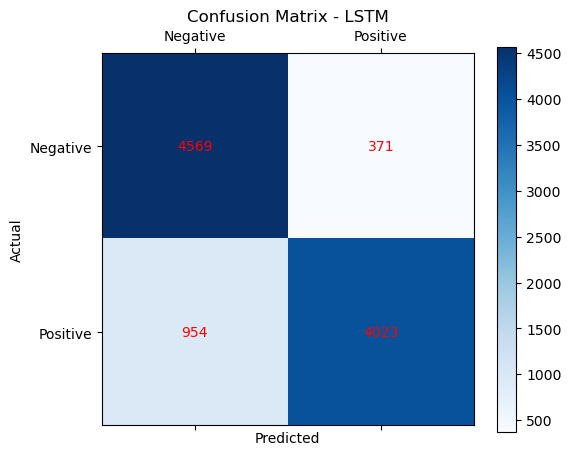

In [27]:
cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(6,5))
cax = ax.matshow(cm, cmap=plt.cm.Blues)  
plt.title('Confusion Matrix - LSTM')
fig.colorbar(cax)

ax.set_xticks([0,1])
ax.set_yticks([0,1])
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_yticklabels(['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, str(cm[i,j]), va='center', ha='center', color='red')

plt.show()

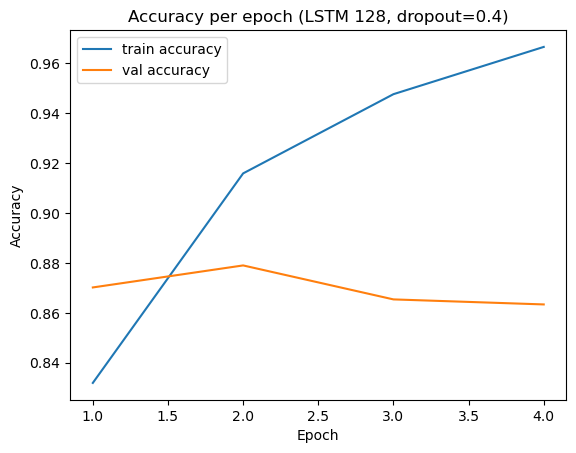

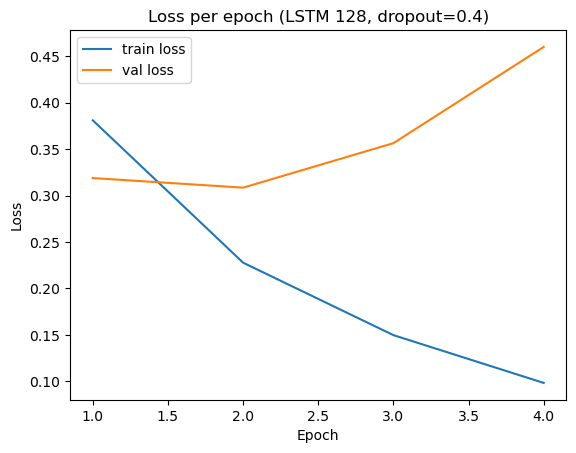

In [28]:
def plot_history(hist, model_desc=""):
    acc = hist.history.get('accuracy', [])
    val_acc = hist.history.get('val_accuracy', [])
    loss = hist.history.get('loss', [])
    val_loss = hist.history.get('val_loss', [])

    epochs = range(1, len(acc) + 1)

    plt.figure()
    plt.plot(epochs, acc, label='train accuracy')
    plt.plot(epochs, val_acc, label='val accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy per epoch {model_desc}')
    plt.legend()
    plt.show()

    plt.figure()
    plt.plot(epochs, loss, label='train loss')
    plt.plot(epochs, val_loss, label='val loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss per epoch {model_desc}')
    plt.legend()
    plt.show()
plot_history(history, "(LSTM 128, dropout=0.4)")


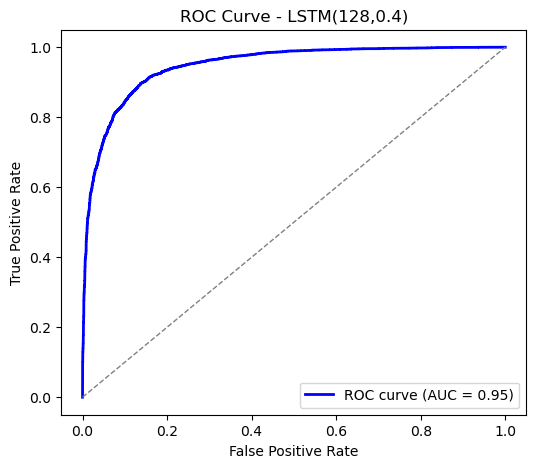

In [29]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0,1], [0,1], color='grey', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM(128,0.4)')
plt.legend(loc='lower right')
plt.show()